In [1]:
from functools import partial
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import RDLogger
import seaborn as sns
from sklearn.model_selection import KFold
import umap

sys.path.insert(0, '../agenticadmet')
from utils import ECFP_from_smiles, standardize, standardize_cxsmiles

[05:11:51] Initializing Normalizer


In [2]:
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

In [3]:
RANDOM_STATE = 42

In [4]:
train = pd.read_csv('../data/asap/raw/train.tsv', sep='\t')
test = pd.read_csv('../data/asap/raw/test.tsv', sep='\t')
train.shape, test.shape

((434, 6), (126, 1))

In [5]:
train

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9
...,...,...,...,...,...,...
429,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN
430,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN
431,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN
432,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN


In [6]:
test

,smiles
0,CC(C)[C@H]1C2=C(CCN1C(=O)CC1=CN=CC3=CC=CC=C13)...
1,CC(C)C1(C)CCN(C(=O)CC2=CN=CC3=CC=CC=C23)CC1
2,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC2=C(C=CS2)C12CCC2
3,CC1(CC(F)(F)F)CCN(C(=O)CC2=CN=CC3=CC=CC=C23)CC1
4,CCC1=CC=C([C@H]2C[C@H](C)CCN2C(=O)CC2=CN=CC3=C...
...,...
121,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...
122,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...
123,COC[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN...
124,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...


In [7]:
train['smiles_std'] = train['smiles'].apply(standardize)
test['smiles_std'] = test['smiles'].apply(standardize)
train['cxsmiles_std'] = train['smiles'].apply(standardize_cxsmiles)
test['cxsmiles_std'] = test['smiles'].apply(standardize_cxsmiles)

In [8]:
train['smiles_std'].isna().sum(), test['smiles_std'].isna().sum()

(0, 0)

In [9]:
Path('../data/asap/preproc/').mkdir(parents=True, exist_ok=True)
train.to_csv('../data/asap/preproc/train.tsv', sep='\t', index=False)
test.to_csv('../data/asap/preproc/test.tsv', sep='\t', index=False)

In [10]:
train_ecfp = np.array(train['smiles'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
test_ecfp = np.array(test['smiles'].apply(partial(ECFP_from_smiles, use_chirality=True)).tolist())
train_ecfp.shape, test_ecfp.shape

((434, 1024), (126, 1024))

/opt/conda/envs/admet/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/admet/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


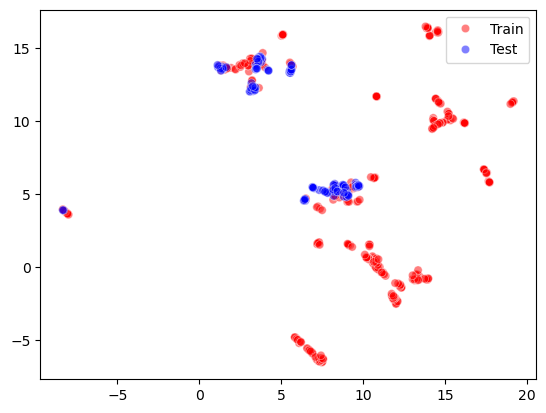

In [11]:
all_ecfp = np.concatenate([train_ecfp, test_ecfp])
all_ecfp_umap = umap.UMAP(
    n_components=2, random_state=RANDOM_STATE, n_jobs=1, metric='jaccard'
).fit_transform(all_ecfp)
sns.scatterplot(
    x=all_ecfp_umap[:, 0], y=all_ecfp_umap[:, 1], 
    hue=['Train']*len(train) + ['Test']*len(test),
    palette={'Train': 'red', 'Test': 'blue'},
    alpha=0.5
);

## Data cleaning & preparation

There are multiple molecules with the same enchanced CXSMILES (see EDA). We should remove molecules with contradicting values. The contradicting values can be determined as the ones outside the normal error range. If for a given duplicate CXSMILES the values are within the error range, we average those values in the group.

In [12]:
columns = ['HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII']

In [ ]:
train['cxsmiles_std'] = train['smiles'].apply(standardize_cxsmiles)
print(f"Number of duplicate SMILES in training set: {train[train['cxsmiles_std'].duplicated()]['cxsmiles_std'].nunique()}")

Number of duplicate SMILES in training set: 30


In [14]:
train['mol_idx'] = train.groupby('cxsmiles_std').ngroup()
train['smiles_ext'] = train['smiles'].map(lambda smi: smi[smi.index('|'):] if '|' in smi else '')

In [15]:
HLM_std, MLM_std, LogD_std, KSOL_std, MDR1_MDCKII_std = train[columns].std()
HLM_std, MLM_std, LogD_std, KSOL_std, MDR1_MDCKII_std

(217.0507262281013,
 318.4791749144294,
 1.2280921175245259,
 157.6780176767439,
 6.433744322214307)

In [16]:
# According to GPT4o, GPT-o3-mini-high and Gemini, the error rate is typically in the following range:
# HLM/MLM: 20-30% of std
# KSOL: 10-20% of std
# LogD: 0.3 log units
# MDR1-MDCKII: 20-30% of std
train['HLM_noisy'] = train.groupby('cxsmiles_std')['HLM'].transform(lambda x: x.max() - x.min() > 0.3 * HLM_std)
train['MLM_noisy'] = train.groupby('cxsmiles_std')['MLM'].transform(lambda x: x.max() - x.min() > 0.3 * MLM_std)
train['LogD_noisy'] = train.groupby('cxsmiles_std')['LogD'].transform(lambda x: x.max() - x.min() > 0.3)
train['KSOL_noisy'] = train.groupby('cxsmiles_std')['KSOL'].transform(lambda x: x.max() - x.min() > 0.2 * KSOL_std)
train['MDR1-MDCKII_noisy'] = train.groupby('cxsmiles_std')['MDR1-MDCKII'].transform(lambda x: x.max() - x.min() > 0.3 * MDR1_MDCKII_std)

In [17]:
train[train['cxsmiles_std'].duplicated(keep=False)].sort_values('cxsmiles_std')[
    [
        'cxsmiles_std', 'mol_idx', 'smiles_ext', 'HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII', 
        'HLM_noisy', 'MLM_noisy', 'LogD_noisy', 'KSOL_noisy', 'MDR1-MDCKII_noisy'
    ]
].head(10)

,cxsmiles_std,mol_idx,smiles_ext,HLM,MLM,LogD,KSOL,MDR1-MDCKII,HLM_noisy,MLM_noisy,LogD_noisy,KSOL_noisy,MDR1-MDCKII_noisy
300,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,12,|o1:4|,100.0,39.0,3.1,104.0,1.010,False,False,False,False,False
294,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,12,|o1:4|,153.0,44.0,3.0,89.0,0.364,False,False,False,False,False
336,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,14,|o1:4|,27.0,10.0,2.7,372.0,1.020,False,False,False,False,False
346,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,14,|o1:4|,42.0,30.0,2.9,390.0,1.530,False,False,False,False,False
293,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3)cc12)c1cc...,30,|o1:3|,169.0,255.0,2.9,111.0,1.180,True,True,True,False,False
292,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3)cc12)c1cc...,30,|o1:3|,405.0,140.0,3.2,111.0,1.500,True,True,True,False,False
291,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,33,|o1:3|,115.0,81.0,4.4,26.0,1.220,False,False,True,False,False
283,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,33,|o1:3|,52.0,147.0,3.4,19.0,2.350,False,False,True,False,False
332,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,37,|o1:3|,935.0,311.0,3.3,22.0,4.330,True,True,True,False,True
333,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,37,|o1:3|,516.0,709.0,3.7,26.0,1.820,True,True,True,False,True


In [18]:
train_clean = train.copy()
for col in columns:
    train_clean[col] = train_clean.groupby('cxsmiles_std')[col].transform('mean')
    train_clean.loc[train_clean[f'{col}_noisy'], col] = np.nan
train_clean

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,HLM_noisy,MLM_noisy,LogD_noisy,KSOL_noisy,MDR1-MDCKII_noisy
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191,|a:16|,False,False,False,False,False
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,False,False,False,False,False
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,False,False,False,False,False
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,False,False,False,False,False
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN,CC(C)NC[C@H](O)COc1cccc2ccccc12,CC(C)NC[C@H](O)COc1cccc2ccccc12 |&1:5|,22,|&1:5|,False,False,False,False,False
430,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,380,,False,False,False,False,False
431,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,,False,False,False,False,False
432,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,166,,False,False,False,False,False


In [19]:
train_clean[train_clean['cxsmiles_std'].duplicated(keep=False)].sort_values('cxsmiles_std')[
    [
        'cxsmiles_std', 'mol_idx', 'smiles_ext', 'HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII', 
        'HLM_noisy', 'MLM_noisy', 'LogD_noisy', 'KSOL_noisy', 'MDR1-MDCKII_noisy'
    ]
].head(10)

,cxsmiles_std,mol_idx,smiles_ext,HLM,MLM,LogD,KSOL,MDR1-MDCKII,HLM_noisy,MLM_noisy,LogD_noisy,KSOL_noisy,MDR1-MDCKII_noisy
300,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,12,|o1:4|,126.5,41.5,3.05,96.5,0.687,False,False,False,False,False
294,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,12,|o1:4|,126.5,41.5,3.05,96.5,0.687,False,False,False,False,False
336,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,14,|o1:4|,34.5,20.0,2.80,381.0,1.275,False,False,False,False,False
346,CC(C)(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(CC(N)=O)c3)...,14,|o1:4|,34.5,20.0,2.80,381.0,1.275,False,False,False,False,False
293,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3)cc12)c1cc...,30,|o1:3|,NaN,NaN,NaN,111.0,1.340,True,True,True,False,False
292,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3)cc12)c1cc...,30,|o1:3|,NaN,NaN,NaN,111.0,1.340,True,True,True,False,False
291,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,33,|o1:3|,83.5,114.0,NaN,22.5,1.785,False,False,True,False,False
283,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,33,|o1:3|,83.5,114.0,NaN,22.5,1.785,False,False,True,False,False
332,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,37,|o1:3|,NaN,NaN,NaN,24.0,NaN,True,True,True,False,True
333,CC(C)[C@H](Nc1ncnc2[nH]c(-c3cnn(C)c3C#N)cc12)c...,37,|o1:3|,NaN,NaN,NaN,24.0,NaN,True,True,True,False,True


In [20]:
train_clean = train_clean[~train_clean['cxsmiles_std'].duplicated()].reset_index(drop=True)
train_clean.drop(columns=['HLM_noisy', 'MLM_noisy', 'LogD_noisy', 'KSOL_noisy', 'MDR1-MDCKII_noisy'], inplace=True)

According to the discussion in [this GitHub issue](https://github.com/asapdiscovery/asap-polaris-blind-challenge-examples/issues/14), we can transform our original values to the `log10(x + 1)` scale:

In [21]:
train_clean['LogHLM'] = np.log10(train_clean['HLM'] + 1)
train_clean['LogMLM'] = np.log10(train_clean['MLM'] + 1)
train_clean['LogKSOL'] = np.log10(train_clean['KSOL'] + 1)
train_clean['LogMDR1-MDCKII'] = np.log10(train_clean['MDR1-MDCKII'] + 1)

In [22]:
def plot_distributions(data, columns):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i, col in enumerate(columns):
        sns.histplot(data[col], ax=ax[i])
        ax[i].set_title(col)
    plt.tight_layout()
    plt.show()

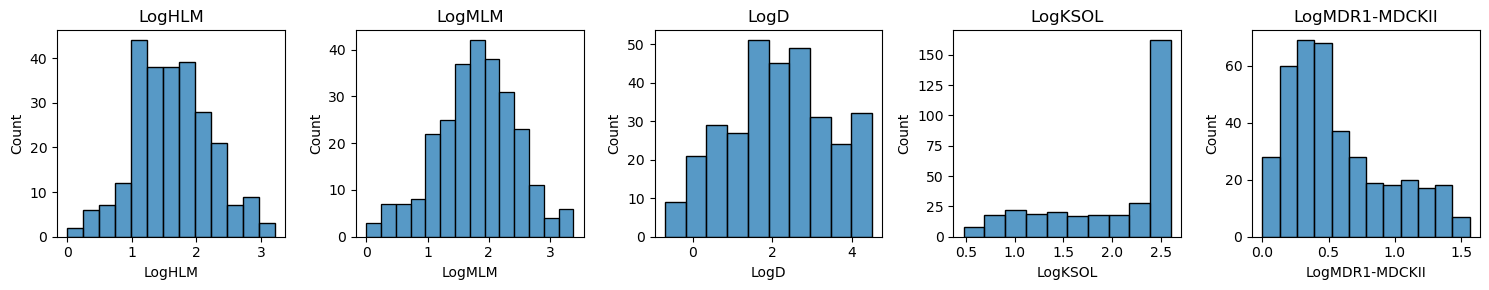

In [23]:
plot_distributions(train_clean, ['LogHLM', 'LogMLM', 'LogD', 'LogKSOL', 'LogMDR1-MDCKII'])

In [24]:
train_clean.shape

(404, 14)

In [25]:
train_clean.to_csv('../data/asap/preproc/train_clean.tsv', index=False, sep='\t')

## Random split

In [26]:
RND_SPLITS_DIR = Path('../data/asap/datasets/rnd_splits')
RND_SPLITS_DIR.mkdir(parents=True, exist_ok=True)

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE).split(train_clean)
for k, (train_idx, val_idx) in enumerate(kfold):
    split = train_clean.copy()
    split['split'] = 'train'
    split.iloc[val_idx, split.columns.get_loc('split')] = 'val'
    split.to_csv(RND_SPLITS_DIR / f'split_{k}.csv', index=False)